# Sensitivity analysis of the POC remineralization

We use a deterministic equation for the POC flux attenuation with depth, accounting for the temperature and oxygen concentration. 

The equation has several parameters whose values where taken from the literature, where various values can be found. 
Thus, we explore the impact of different parametrization of this equation on the POC flux as well as the impact of taking into account only T, O2 or both.

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
import os
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc').sel(latitude=slice(-80, -45))
MLD = xr.open_dataset('MLD_summer_SO_interpolated.nc').sel(latitude=slice(-80, -45))
thetao = xr.open_dataset('thetao_summer_SO_interpolated.nc').sel(latitude=slice(-80, -45))
oxygen = xr.open_dataset('oxygen_summer_SO_interpolated.nc').sel(latitude=slice(-80, -45))

In [3]:
oxygen

<xarray.Dataset>
Dimensions:    (latitude: 18, longitude: 180, depth: 49)
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... -53 -51 -49 -47 -45
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * depth      (depth) float64 0.5058 9.869 19.89 ... 5.414e+03 5.75e+03
Data variables:
    o2         (depth, latitude, longitude) float32 ...

# 1. test the influence of the temperature and oxygen dependance

### Remineralization rate - accounting or not for the environmental conditions 

We account for two environmental drivers : the local temperature and oxygen concentration.
Thus, the flux function can be rewritten to integrate T, O2 or both.

We can add two terms to account for the temperature and the oxygen dependance. These terms can be removed alternatively to test for the influence of only of variable at a time. 

$$ 𝐹𝐹𝑃_{𝑧} = 𝑓𝑝𝑝 \times 𝑒^{(-\frac{𝑘𝑟𝑒𝑚𝑖𝑛}{𝑊𝑠𝑖𝑛𝑘} \times T_{dep} \times O2_{dep} \times (𝑧 − 𝑧_{0}))} $$

- Terme of temperature dependance :

$T_{dep} = Q_{10}^{\frac{T-T_{ref}}{10}}$
with $T_{ref}$ a temperature of reference.

- Terme of oxygen dependance :

$O2_{dep} = \frac{[O_2]}{[O_2] + K_{O2}} $ 

In [4]:
# tests with different starting depth 
# z = a given depth at wich the flux is calculated
#z0 = the starting depth of the attenuation curve
# dep = str to indicate which environnemental drivers should be considered : N=None, T= Temp only, O= O2 only, TO=temp and O2
# ffp0 = the POC flux at the starting depth
# Tloc and O2loc = the local temperature and O2 level (if needed)

def attenuation(z, z0, dep, ffp0, Tloc, O2loc):
    if dep == 'N':
        remin_rate = -k_remin_ref/(wsink)
    
    if dep == 'T':
        remin_rate = ((-k_remin_ref)/(wsink)) * (Q10**((Tloc-Tref)/10))
    
    if dep == 'O':
        remin_rate = ((-k_remin_ref)/(wsink)) * ((O2loc)/(O2loc+KO2))
    
    if dep == 'TO':
        remin_rate = ((-k_remin_ref)/(wsink)) * (Q10**((Tloc-Tref)/10)) * ((O2loc)/(O2loc+KO2))
        
    ffpz = ffp_z0*math.exp(remin_rate*(z-z0))
    return(ffpz)
    

In [5]:
# Values of parameters 
k_remin_ref = 0.25 # /day
Q10 = 2 # no units

Tref = 5 # °C

ffp_z0 = 100 # arbitrary initial flux (mgC/m²/day)
wsink = 233 # m/day
KO2 = 9.9 #µmol/L

In [6]:
# values en envir variables for the example => to be change
Tnew = thetao.to_dataframe().mean().iloc[0] # °C => to be changes with envir data
O2 = oxygen.to_dataframe().mean().iloc[0]  #µmol/L = mmol/m3
z = np.asarray(OCIM['depth'])

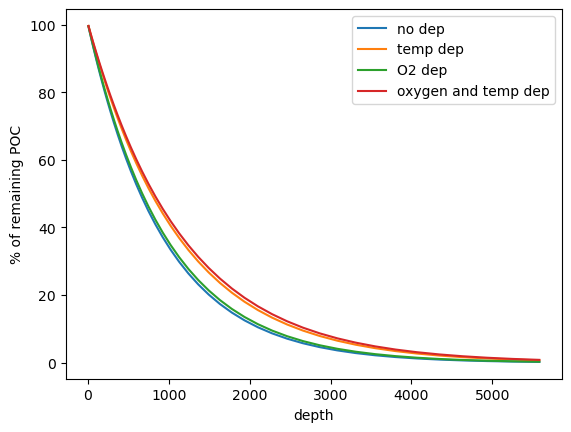

In [28]:
# with no dependence
ffpz = []

for i in range(len(z)):
    x = attenuation(z = z[i], z0 = 0, dep = 'N', ffp0 = 100, Tloc = None, O2loc=None)
    ffpz.append(x)
    
# with temperature dep, z0 = 0
ffpz_T = []

for i in range(len(z)):
    x = attenuation(z = z[i], z0 = 0, dep = 'T', ffp0 = 100, Tloc = Tnew, O2loc=None)
    ffpz_T.append(x)

#with O2 and z0=0
ffpz_O2= []

for i in range(len(z)):
    x = attenuation(z = z[i], z0 = 0, dep = 'O', ffp0 = 100, Tloc = None, O2loc=O2)
    ffpz_O2.append(x)
    
#with T+O2 and z0=0
ffpz_TO2= []

for i in range(len(z)):
    x = attenuation(z = z[i], z0 = 0, dep = 'TO', ffp0 = 100, Tloc = Tnew, O2loc=O2)
    ffpz_TO2.append(x)
    
# Plots, (depends on the values of T and O2 dep!)
plt.plot(z, ffpz, label = "no dep")
plt.plot(z, ffpz_T, label = "temp dep")
plt.plot(z, ffpz_O2, label = "O2 dep")
plt.plot(z, ffpz_TO2, label = "oxygen and temp dep")
plt.ylabel("% of remaining POC")
plt.xlabel("depth")
plt.legend()

#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/sensitivity_analyses/')
#plt.savefig('attenuation_curve_depversions.png')

# Compare the mean time of sequestration between the 4 cases

To do this we take the "no dep" calculation as th reference and we compare each of the three types of envir dependencies to this reference by making the difference of the datsests of plotting that "delta".

In [22]:
# load the files
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/sensitivity_analyses/')
no_dep = xr.open_dataset('Mean_time_seq_no_dep.nc')
T_dep = xr.open_dataset('Mean_time_seq_T_dep.nc')
O2_dep = xr.open_dataset('Mean_time_seq_O2_dep.nc')
O2_T_dep = xr.open_dataset('Mean_time_seq_O2_T_dep.nc')

In [23]:
# make the difference between each datasets and the 'reference' which is the 'no dep'
#diff_T = no_dep - T_dep
#diff_O2 = no_dep - O2_dep
#diff_O2_T = no_dep - O2_T_dep

diff_no_dep = 100*(O2_T_dep - no_dep)/O2_T_dep # min = -60.50542106 max = 100, mean = 11
diff_O2 = 100*(O2_T_dep - O2_dep)/O2_T_dep # min = -55.69778974 max = 100, mean = 9.3
diff_T = 100*(O2_T_dep - O2_T_dep)/O2_T_dep # min = 0 max = 0

In [24]:
diff_O2.__xarray_dataarray_variable__.mean()

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(9.32784917)

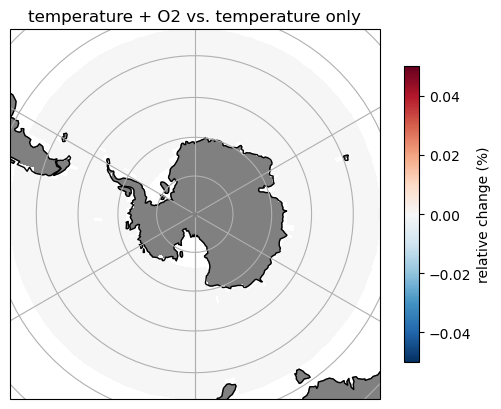

In [25]:
# plot the results
map_proj = ccrs.SouthPolarStereo()

p = diff_T.to_array().plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap="RdBu_r",
    #title = 'mean time of carbon sequesration'
)  # the plot's projection

#p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'relative change (%)', shrink = 0.8)
plt.title('temperature + O2 vs. temperature only')

plt.savefig('TO2vsT.png')

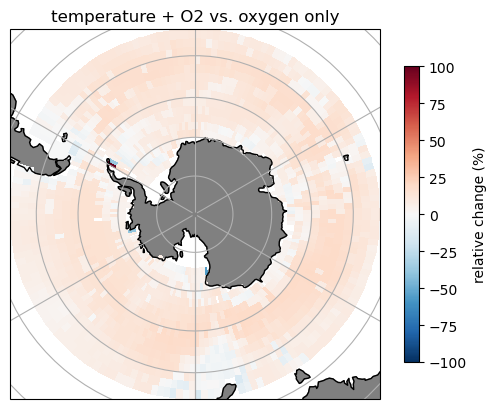

In [26]:
# plot the results
map_proj = ccrs.SouthPolarStereo()

p = diff_O2.to_array().plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
    #title = 'mean time of carbon sequesration'
)  # the plot's projection

#p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'relative change (%)', shrink = 0.8)
plt.title('temperature + O2 vs. oxygen only')

plt.savefig('TO2vsO2.png')

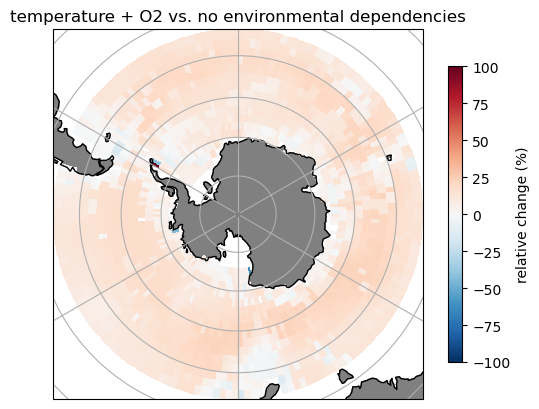

In [27]:
# plot the results
map_proj = ccrs.SouthPolarStereo()

p = diff_no_dep.to_array().plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
    #title = 'mean time of carbon sequesration'
)  # the plot's projection

#p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'relative change (%)', shrink = 0.8)
plt.title('temperature + O2 vs. no environmental dependencies')

plt.savefig('TO2vsnodep.png')


# test the sensitivity of the parameters of the remineralization curve

To test the sensitivy of the parameters used in the remineralization rate we tested differents sets of parameters to calculate the attenuation curve and then the mean time of carbon sequestration.

In [10]:
def attenuation_params(z, z0, ffp0, Tloc, O2loc, k_remin_ref, wsink, Q10, Tref, KO2):
    remin_rate = ((-k_remin_ref)/(wsink)) * (Q10**((Tloc-Tref)/10)) * ((O2loc)/(O2loc+KO2)) 
    ffpz = ffp_z0*math.exp(remin_rate*(z-z0))
    return(ffpz)

In [11]:
# Values of parameters 
Q10 = 2 # no units

Tref = 5 # °C

ffp_z0 = 100 # arbitrary initial flux (mgC/m²/day)
wsink = 233 # m/day
k_remin_ref = 0.25
KO2 = 9.9 #µmol/L

In [12]:
# values en envir variables for the example => to be change
Tnew = thetao.to_dataframe().mean().iloc[0] # °C => to be changes with envir data
O2 = oxygen.to_dataframe().mean().iloc[0]  #µmol/L = mmol/m3
z = np.asarray(OCIM['depth'])

## Test the sensitivity to the base remineralization rate
test: 0.2; 0.25; 0.3
with the other parametrs set to the values used in the rest of the study.

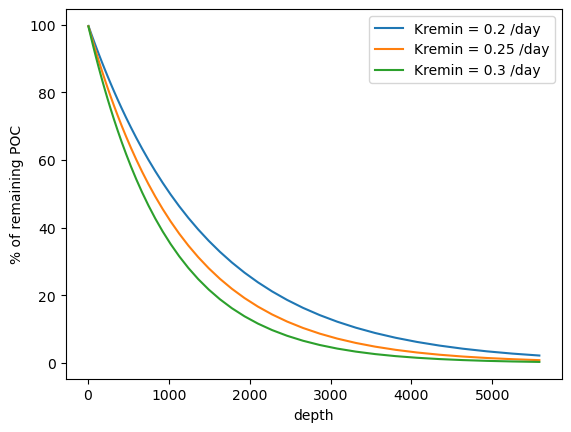

In [13]:
#with T+O2 and z0=0
sets= []

for k in [0.2, 0.25, 0.3]:
    ffpz=[]
    for i in range(len(z)):
        x = attenuation_params(z = z[i], z0 = 0, ffp0 = 100, Tloc = Tnew, O2loc=O2, k_remin_ref=k, wsink=wsink, Q10=Q10, Tref=Tref, KO2=KO2)
        ffpz.append(x)
    sets.append(ffpz)

# Plots, (depends on the values of T and O2 dep!)
plt.plot(z, sets[0], label = "Kremin = 0.2 /day")
plt.plot(z, sets[1], label = "Kremin = 0.25 /day")
plt.plot(z, sets[2], label = "Kremin = 0.3 /day")
plt.ylabel("% of remaining POC")
plt.xlabel("depth")
plt.legend()
plt.savefig('attenuation_curve_Kremin.png')

In [14]:
# calculate the mean of the difference, on absolute numbers, between the 3 curve
D_low_mid = np.abs(np.subtract(np.array(sets[1]), np.array(sets[0])))
D_mid_hig = np.abs(np.subtract(np.array(sets[1]), np.array(sets[2])))
mean_delta_k = np.mean((D_mid_hig + D_low_mid)) # 7.87
mean_delta_k

7.872807932262648

## Test the influence of the Wsink
test : the range found in Pauli et al 2021 > 79, 233, 387 m/day

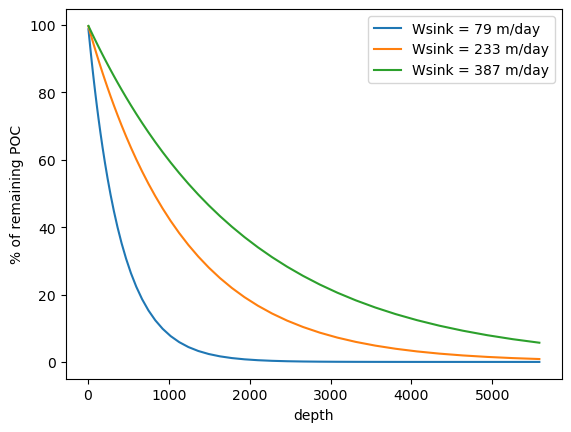

In [15]:
#with T+O2 and z0=0
sets= []

for w in [79, 233, 387]:
    ffpz=[]
    for i in range(len(z)):
        x = attenuation_params(z = z[i], z0 = 0, ffp0 = 100, Tloc = Tnew, O2loc=O2, k_remin_ref=k_remin_ref, wsink=w, Q10=Q10, Tref=Tref, KO2=KO2)
        ffpz.append(x)
    sets.append(ffpz)

# Plots, (depends on the values of T and O2 dep!)
plt.plot(z, sets[0], label = "Wsink = 79 m/day")
plt.plot(z, sets[1], label = "Wsink = 233 m/day")
plt.plot(z, sets[2], label = "Wsink = 387 m/day")
plt.ylabel("% of remaining POC")
plt.xlabel("depth")
plt.legend()
plt.savefig('attenuation_curve_Wsink.png')

In [16]:
# calculate the mean of the difference, on absolute numbers, between the 3 curve
D_low_mid = np.abs(np.subtract(np.array(sets[1]), np.array(sets[0])))
D_mid_hig = np.abs(np.subtract(np.array(sets[1]), np.array(sets[2])))
mean_delta_w = np.mean((D_mid_hig + D_low_mid)) # 28.47
mean_delta_w

28.473311023386685

## Test the influence of the temperature terms
The terms has tw parameters that should be set together.
We test two sets: 
1: Q10 = 2 and Tref = 5
2: Q10 = 2.4 and Tref = 4

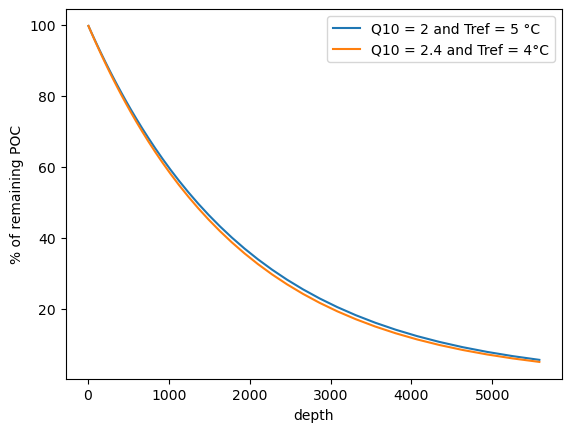

In [17]:
#with T+O2 and z0=0
sets= []

# first set of params
ffpz=[]
for i in range(len(z)):
    x = attenuation_params(z = z[i], z0 = 0, ffp0 = 100, Tloc = Tnew, O2loc=O2, k_remin_ref=k_remin_ref, wsink=w, Q10=2, Tref=5, KO2=KO2)
    ffpz.append(x)
sets.append(ffpz)

# second set of params
ffpz=[]
for i in range(len(z)):
    x = attenuation_params(z = z[i], z0 = 0, ffp0 = 100, Tloc = Tnew, O2loc=O2, k_remin_ref=k_remin_ref, wsink=w, Q10=2.4, Tref=4, KO2=KO2)
    ffpz.append(x)
sets.append(ffpz)

# Plots, (depends on the values of T and O2 dep!)
plt.plot(z, sets[0], label = "Q10 = 2 and Tref = 5 °C")
plt.plot(z, sets[1], label = "Q10 = 2.4 and Tref = 4°C")
plt.ylabel("% of remaining POC")
plt.xlabel("depth")
plt.legend()
plt.savefig('attenuation_curve_Temp.png')

In [18]:
# calculate the mean of the difference, on absolute numbers, between the 3 curve
D = np.abs(np.subtract(np.array(sets[1]), np.array(sets[0])))
mean_delta_T = np.mean((D)) # 0.76
mean_delta_T

0.7651620337669272

## Test the influence of the oxygen terms
We test KO2 = 4, 9.9, 12 µmol/L

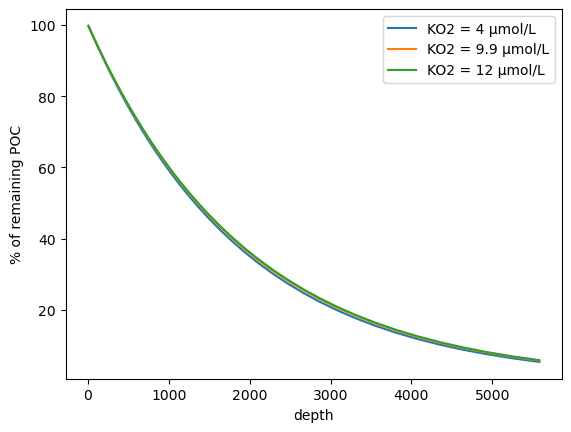

In [19]:
sets= []

for ko in [4, 9.9, 12]:
    ffpz=[]
    for i in range(len(z)):
        x = attenuation_params(z = z[i], z0 = 0, ffp0 = 100, Tloc = Tnew, O2loc=O2, k_remin_ref=k_remin_ref, wsink=w, Q10=Q10, Tref=Tref, KO2=ko)
        ffpz.append(x)
    sets.append(ffpz)

# Plots, (depends on the values of T and O2 dep!)
plt.plot(z, sets[0], label = "KO2 = 4 µmol/L")
plt.plot(z, sets[1], label = "KO2 = 9.9 µmol/L")
plt.plot(z, sets[2], label = "KO2 = 12 µmol/L")
plt.ylabel("% of remaining POC")
plt.xlabel("depth")
plt.legend()
plt.savefig('attenuation_curve_KO2.png')

In [20]:
# calculate the mean of the difference, on absolute numbers, between the 3 curve
D_low_mid = np.abs(np.subtract(np.array(sets[1]), np.array(sets[0])))
D_mid_hig = np.abs(np.subtract(np.array(sets[1]), np.array(sets[2])))
mean_delta_ko2 = np.mean((D_mid_hig + D_low_mid)) # 0.62
mean_delta_ko2

0.6227170781980716

Text(0, 0.5, 'Average in the POC attenuation curve')

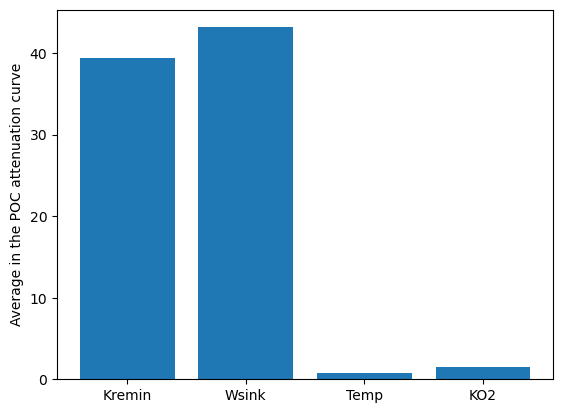

In [21]:
# plot de deltas
height = [mean_delta_k/0.2, mean_delta_w/0.66, mean_delta_T, mean_delta_ko2/0.4]
bars = ('Kremin', 'Wsink', 'Temp', 'KO2')

plt.bar(bars, height)
plt.ylabel('Average in the POC attenuation curve')
#plt.savefig('barplot_deltas_params.png')